In [9]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers



In [13]:
import tensorflow as tf

# Load MNIST dataset directly
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize the images to [-1, 1]
train_images = (train_images.astype('float32') - 127.5) / 127.5
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)

print("Training data shape:", train_images.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 23s 2us/step
Training data shape: (60000, 28, 28, 1)


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers


In [15]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# Initialize generator
generator = make_generator_model()


/Users/rahatrihan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Initialize discriminator
discriminator = make_discriminator_model()


/Users/rahatrihan/miniforge3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [18]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Prepare the dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Seed for image generation consistency
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        print(f'Epoch {epoch + 1}/{epochs} completed')
        generate_and_save_images(generator, epoch + 1, seed)


In [19]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()


2025-01-16 19:58:01.473634: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/50 completed


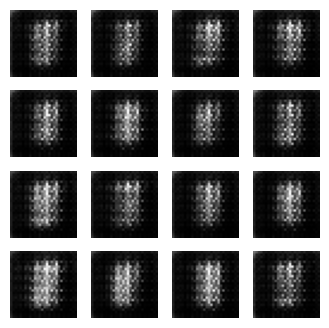

Epoch 2/50 completed


2025-01-16 19:59:18.361957: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


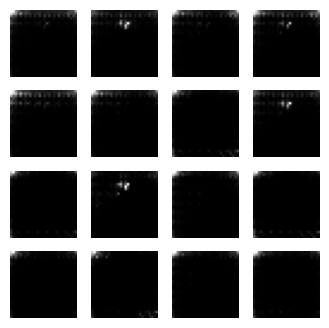

Epoch 3/50 completed


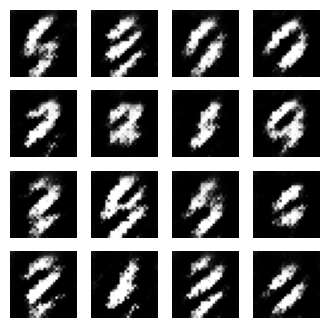

Epoch 4/50 completed


2025-01-16 20:01:52.752105: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


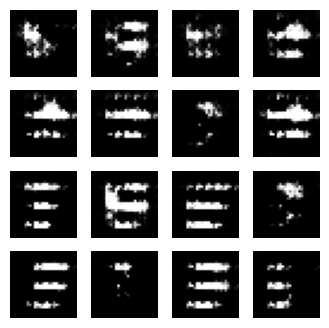

Epoch 5/50 completed


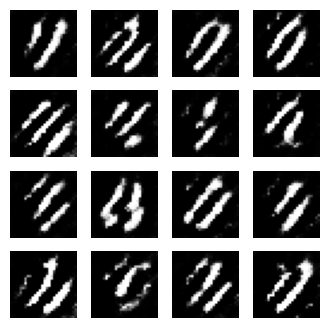

Epoch 6/50 completed


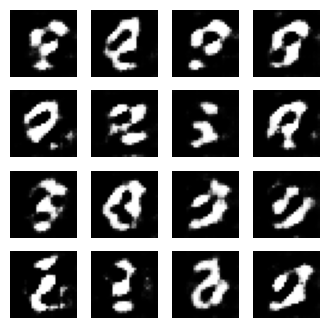

Epoch 7/50 completed


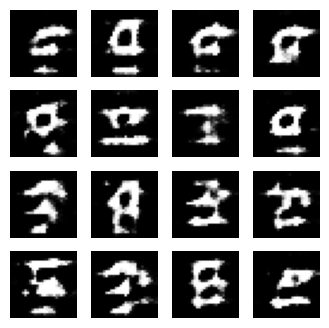

Epoch 8/50 completed


2025-01-16 21:17:52.456102: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


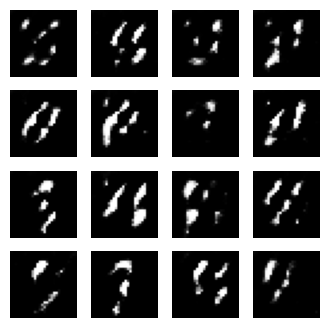

Epoch 9/50 completed


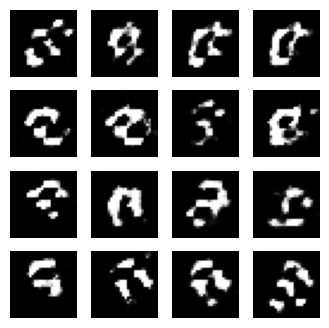

Epoch 10/50 completed


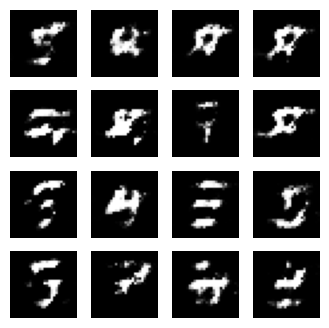

Epoch 11/50 completed


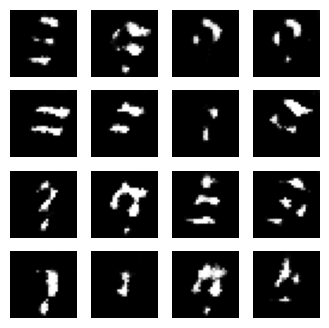

Epoch 12/50 completed


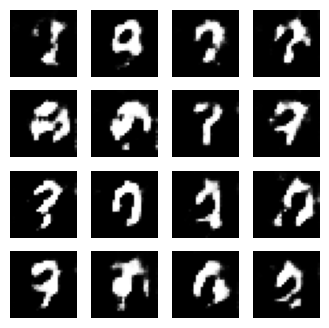

Epoch 13/50 completed


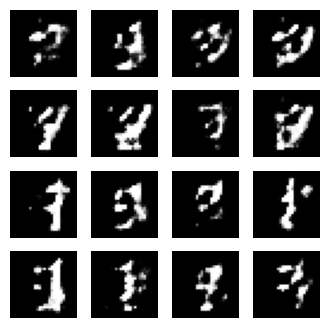

Epoch 14/50 completed


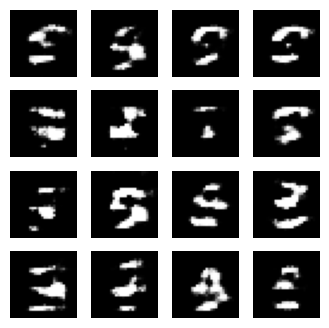

Epoch 15/50 completed


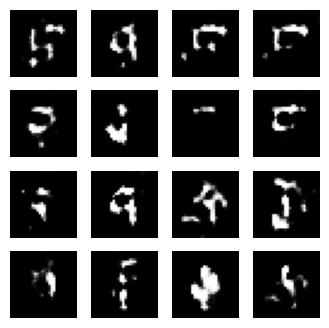

Epoch 16/50 completed


2025-01-16 21:28:04.425991: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


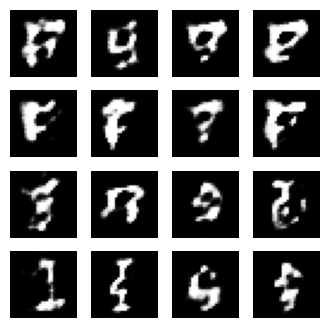

Epoch 17/50 completed


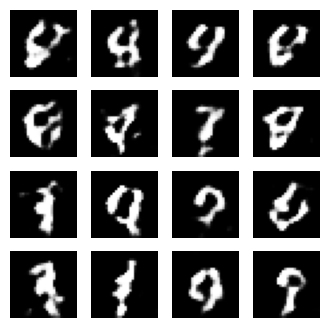

Epoch 18/50 completed


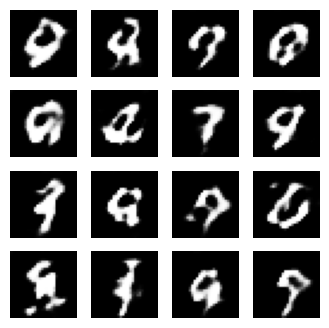

Epoch 19/50 completed


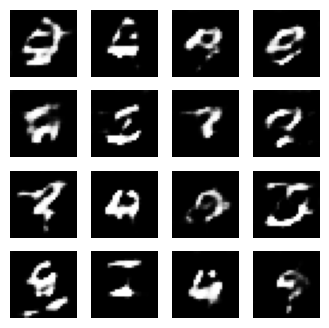

Epoch 20/50 completed


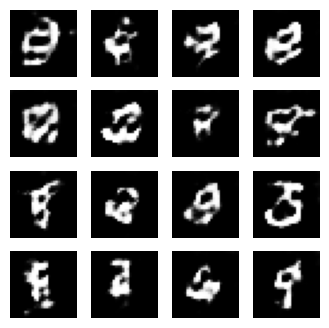

Epoch 21/50 completed


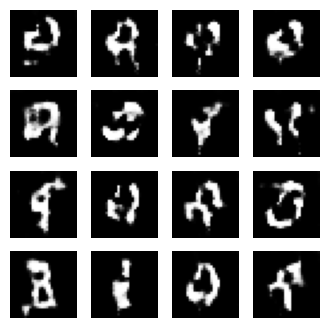

Epoch 22/50 completed


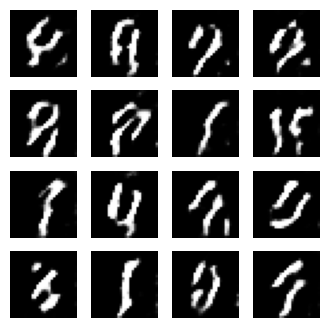

Epoch 23/50 completed


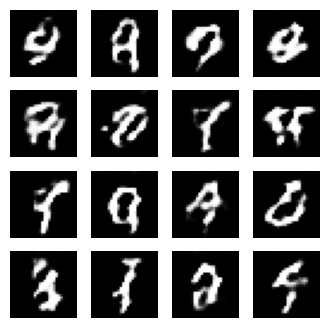

Epoch 24/50 completed


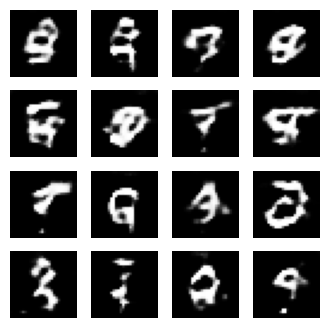

Epoch 25/50 completed


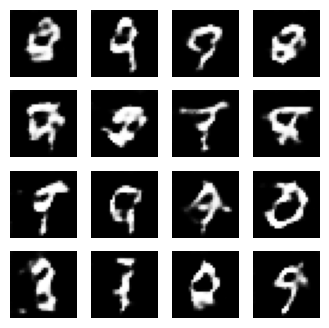

Epoch 26/50 completed


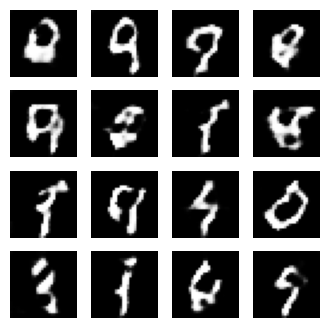

Epoch 27/50 completed


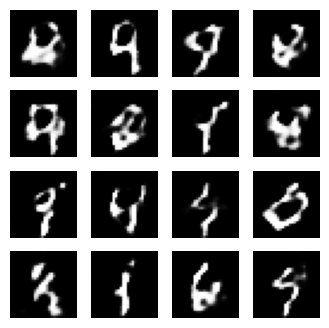

Epoch 28/50 completed


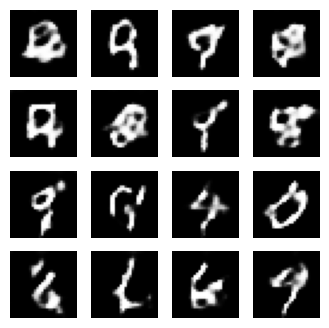

Epoch 29/50 completed


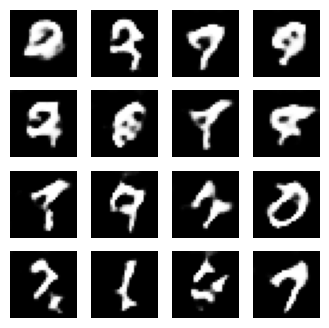

Epoch 30/50 completed


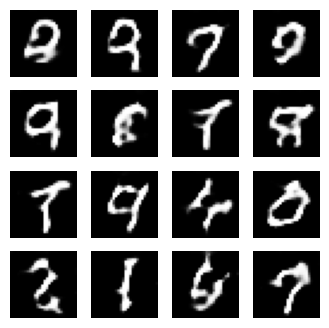

Epoch 31/50 completed


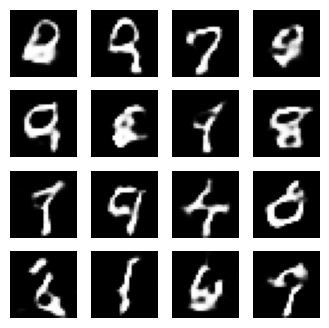

Epoch 32/50 completed


2025-01-16 21:48:20.030642: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


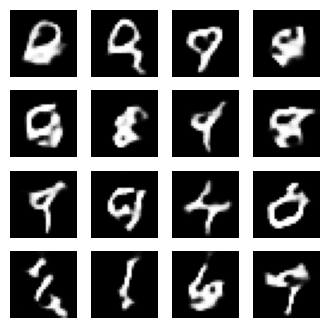

Epoch 33/50 completed


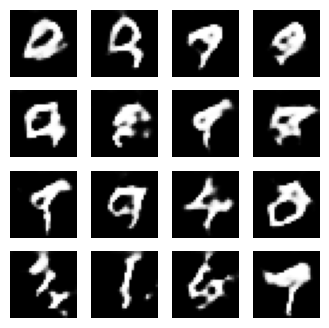

Epoch 34/50 completed


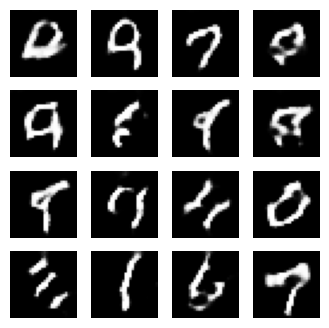

Epoch 35/50 completed


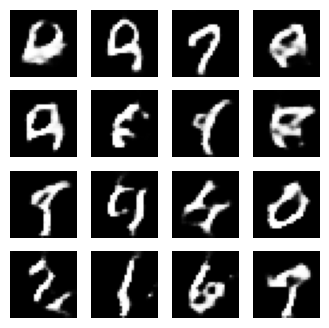

Epoch 36/50 completed


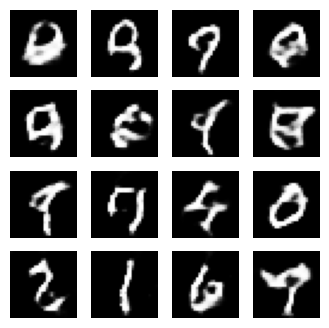

Epoch 37/50 completed


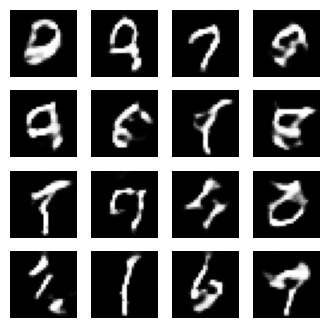

Epoch 38/50 completed


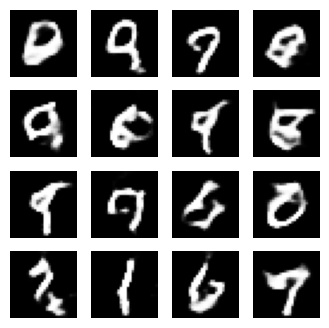

Epoch 39/50 completed


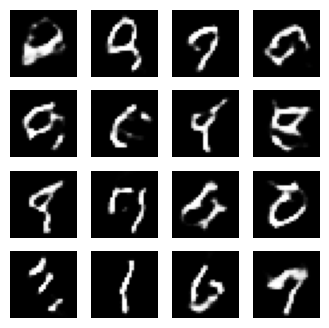

Epoch 40/50 completed


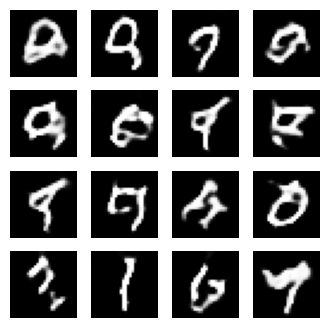

Epoch 41/50 completed


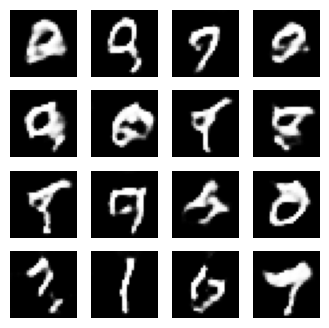

Epoch 42/50 completed


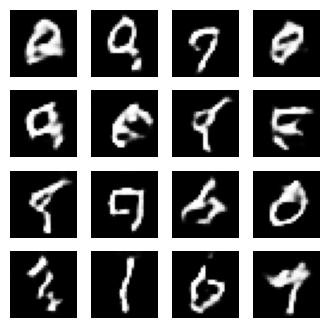

In [ ]:
train(train_dataset, EPOCHS)
